In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import methods
import pymaster as nmt
from importlib import reload

/tmp/ipykernel_20421/400164470.py:4: RuntimeWarning: invalid value encountered in true_divide
  input_cl /= ell_input*(ell_input+1)/2/np.pi


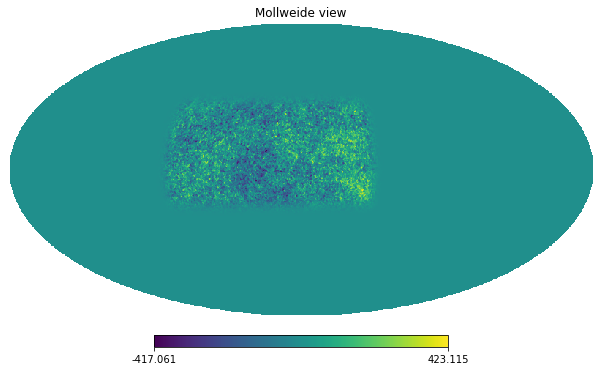

In [2]:
reload(methods)
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
input_cl = np.array([TT, TE, EE, BB])
input_cl /= ell_input*(ell_input+1)/2/np.pi 
for c in input_cl: c[0] = 0

nside = 128
lmax = 3*nside-1
npix = 12*nside**2
pixels_lr, pixels_ud = methods.create_pixels()
rate = 10 #hz

TT = input_cl[0]
input_map = hp.synfast(TT, nside)
mask = np.zeros(npix)
mask[pixels_lr] = 1
mask_apo = nmt.mask_apodization(mask, 2.5, apotype="Smooth")    
hp.mollview(mask_apo * input_map)

In [5]:
reload(methods)
ells, cl_fb = methods.sim_cl2cl(np.ones(lmax+1), (pixels_lr, pixels_ud), rate, n_sims=100, n_obs=10, bin_size=16,replace=False)
ells, cl_fbt = methods.sim_cl2cl(np.ones(lmax+1), (pixels_lr, pixels_ud), rate, n_sims=100, n_obs=10, noise_params=None, bin_size=16,replace=False)
ells, cl_fr = methods.sim_cl2cl(np.ones(lmax+1), (pixels_lr, pixels_ud), rate, n_sims=100, n_obs=10, bin_size=16, replace=True)

100%|█████████████████████████████████████████| 100/100 [10:47<00:00,  6.48s/it]


In [5]:
# ells = np.load('ells.npy')
# cl_fb = np.load('cl_fb.npy')
# cl_fbt = np.load('cl_fbt.npy')
# cl_fr = np.load('cl_fr.npy')

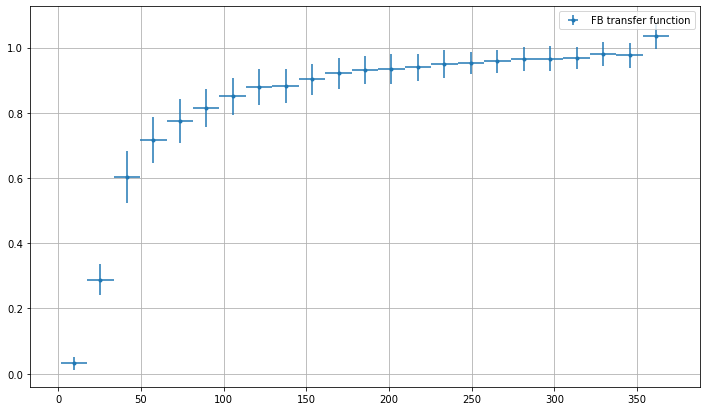

In [6]:
#Gaussian method
fbt_mean = np.mean(cl_fbt, axis=0)
fbt_std = np.std(cl_fbt, axis=0)

fb_mean = np.mean(cl_fb, axis=0)
fb_std = np.std(cl_fb, axis=0)

fr_mean = np.mean(cl_fr, axis=0)
fr_std = np.std(cl_fr, axis=0)

xerr=np.median(np.diff(ells))/2

plt.figure(figsize=(12,7))
plt.errorbar(ells, fbt_mean, yerr=fbt_std, xerr=xerr, fmt='.', label='FB transfer function')
plt.grid()
plt.legend()

In [7]:
# # Divide out FT with MC

# fbc_mean = np.zeros_like(fb_mean)
# fbc_std = np.zeros_like(fb_std)

# for i in range(len(ells)):
#     cl_fbc = []
#     for j in range(cl_fb.shape[0]):
#         for k in range(cl_fbt.shape[0]):
#             cl_fbc.append(cl_fb[:,i][j]/cl_fbt[:,i][k])
#     fbc_mean[i], fbc_std[i] = np.mean(cl_fbc), np.std(cl_fbc)

In [8]:
# # Naive method? Pick this or cell below

# cl_fbc = cl_fb/cl_fbt

# fbc_mean = np.mean(cl_fbc, axis=0)
# fbc_std = np.std(cl_fbc, axis=0)

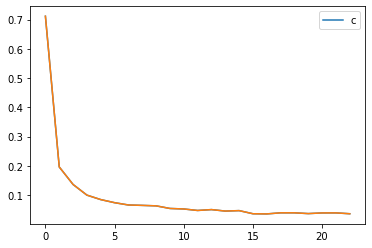

In [9]:
# KEEP SAME RELATIVE ERROR 
fbc_mean = fb_mean/fbt_mean

fbc_std = fb_std * fbc_mean/fb_mean

plt.plot(fbc_std/fbc_mean, label='c')
plt.plot(fb_std/fb_mean)

plt.legend()

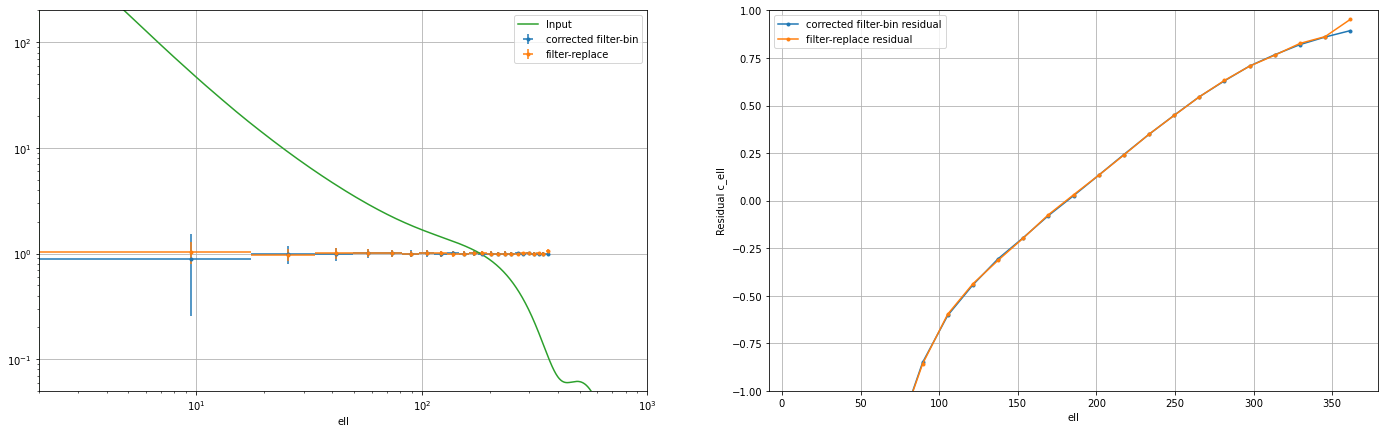

In [10]:
fig, axes = plt.subplots(1,2, figsize=(24, 7))
interp_input = np.interp(ells, ell_input, TT)

# axes[0].errorbar(ells, fb_mean, yerr=fb_std, xerr=xerr, fmt='.', label='uncorrected filter-bin')
axes[0].errorbar(ells, fbc_mean, yerr=fbc_std, xerr=xerr, fmt='.', label='corrected filter-bin')
axes[0].errorbar(ells, fr_mean, yerr=fr_std, xerr=xerr, fmt='.', label='filter-replace')
axes[0].plot(ell_input, TT, label='Input')
axes[0].set_xlim([2e0,1e3])
axes[0].set_ylim([5e-2,2e2])
axes[0].loglog()

axes[1].plot(ells, fbc_mean - interp_input , marker='.', label='corrected filter-bin residual')
axes[1].plot(ells, fr_mean - interp_input, marker='.', label='filter-replace residual')

axes[1].set_ylabel('Residual c_ell')
axes[1].set_ylim([-1, 1])

for ax in axes:
    ax.set_xlabel('ell')
    ax.legend()
    ax.grid()    

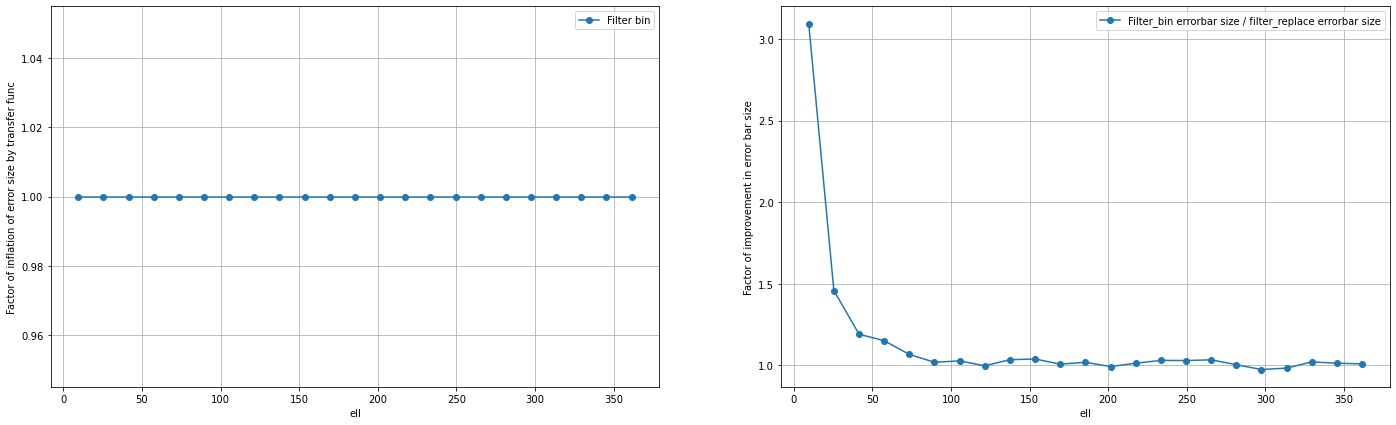

In [12]:
fig, axes = plt.subplots(1,2, figsize=(24, 7))
axes[0].plot(ells, (fbc_std/fbc_mean) / (fb_std/fb_mean), marker='o', label='Filter bin')
axes[0].set_ylabel('Factor of inflation of error size by transfer func')

axes[1].plot(ells, (fbc_std/fbc_mean)/(fr_std/(fr_mean)), marker='o', label='Filter_bin errorbar size / filter_replace errorbar size')
axes[1].set_ylabel('Factor of improvement in error bar size')

for ax in axes:
    ax.grid()
    ax.legend()
    ax.set_xlabel('ell')
#     ax.set_ylim([1,3])

In [ ]:
# fbt_l, fbt_m, fbt_h = np.percentile(cl_fbt, [2.5,50,97.5], axis=0) 
# fb_l, fb_m, fb_h = np.percentile(cl_fb, [2.5,50,97.5], axis=0) 

# plt.figure(figsize=(12,7))
# plt.errorbar(ells, fbt_m, (fbt_m-fbt_l,fbt_h-fbt_m), fmt='.', label='FB transfer function')
# plt.errorbar(ells, frt_m, (frt_m-frt_l,frt_h-frt_m), fmt='.', label='FR transfer function')
# plt.plot(ells, np.interp(ells, np.arange(lmax+1), hp.gauss_beam(fwhm=np.deg2rad(0.5), lmax=lmax)))
# plt.grid()
# plt.legend()

In [ ]:
# rng = np.random.default_rng()

# fbc_m = np.zeros_like(fb_m)
# fbc_l = np.zeros_like(fb_l)
# fbc_h = np.zeros_like(fb_h)

# for i in range(len(ells)):
#     cl_fbc = [cl_fb[:,i][rng.integers(0, cl_fb.shape[0])] / cl_fbt[:,i][rng.integers(0, cl_fbt.shape[0])] for j in range(1000)]
#     l, m, h = np.percentile(cl_fbc, [2.5,50,97.5]) 
#     fbc_l[i] = l
#     fbc_m[i] = m
#     fbc_h[i] = h

# frc_m = np.zeros_like(fr_m)
# frc_l = np.zeros_like(fr_l)
# frc_h = np.zeros_like(fr_h)

# for i in range(len(ells)):
#     cl_frc = [cl_fr[:,i][rng.integers(0, cl_fr.shape[0])] / cl_frt[:,i][rng.integers(0, cl_frt.shape[0])] for j in range(1000)]
#     l, m, h = np.percentile(cl_frc, [2.5,50,97.5]) 
#     frc_l[i] = l
#     frc_m[i] = m
#     frc_h[i] = h

In [ ]:
# fig, axes = plt.subplots(1,2, figsize=(24, 7))
# interp_input = np.interp(ells, ell_input, TT)

# # axes[0].errorbar(ells, fb_m, (fb_m-fb_l,fb_h-fb_m), fmt='.', label='uncorrected filter-bin')
# axes[0].errorbar(ells, fbc_m, (fbc_m-fbc_l,fbc_h-fbc_m), fmt='.', label='corrected filter-bin')
# axes[0].errorbar(ells, fr_m, (fr_m-fr_l,fr_h-fr_m), fmt='.', label='filter-replace')
# # axes[0].errorbar(ells, frc_m, (frc_m-frc_l,frc_h-frc_m), fmt='.', label='corrected filter-replace')
# axes[0].plot(ell_input, TT, label='Input')
# axes[0].set_xlim([2e0,1e3])
# axes[0].set_ylim([1e-2,2e3])
# axes[0].loglog()

# axes[1].plot(ells, fbc_m - interp_input , marker='.', label='corrected filter-bin residual')
# axes[1].plot(ells, fr_m - interp_input, marker='.', label='filter-replace residual')
# # axes[1].plot(ells, frc_m - interp_input, marker='.', label='corrected filter-replace residual')

# axes[1].set_ylabel('Residual c_ell')
# axes[1].set_ylim([-2, 2])

# for ax in axes:
#     ax.set_xlabel('ell')
#     ax.legend()
#     ax.grid()    

In [ ]:
# interp_input = np.interp(ells, ell_input, TT)

# fig, axes = plt.subplots(1,2, figsize=(24, 7))
# axes[0].plot(ells, ((fbc_h-fbc_l)/fbc_m) / ((fb_h-fb_l)/fb_m), linestyle='dashed', label='Filter bin')
# axes[0].plot(ells, ((frc_h-frc_l)/frc_m) / ((fr_h-fr_l)/fr_m), linestyle='dashed', label='Filter replace')
# axes[0].set_ylabel('Factor of inflation of error size by transfer func')

# # axes[1].plot(ells, ((fbc_h-fbc_l)/fbc_m)/((frc_h-frc_l)/(frc_m)), linestyle='dashed', label='Filter_bin errorbar size / corrected_filter_replace errorbar size')
# axes[1].plot(ells, ((fbc_h-fbc_l)/fbc_m)/((fr_h-fr_l)/(fr_m)), linestyle='dashed', label='Filter_bin errorbar size / filter_replace errorbar size')
# axes[1].set_ylabel('Factor of improvement in error bar size')
# # axes[1].set_ylim([0,12])

# for ax in axes:
#     ax.grid()
#     ax.legend()
#     ax.set_xlabel('ell')